# L'objectif du script est de :
- Créer les dernières variables prix au m² par commune et par "bloc" GPS (afin de reproduire une information du type prix au m² par quartier, les codes IRIS étant devenus indisponibles dans l'API du gouvernement)
- Choisir les features à conserver pour entraîner le modèle
- Entraîner et exporter le modèle final qui permettra de prédire les prix à partir d'un ensemble de features d'une annonce immo
- Ajouter une couche d'interprétabilité du modèle

In [1]:
import pandas as pd
import numpy as np
import unidecode
import joblib

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

Objectif du notebook : 

Tester la performance des algos de régression sur une base à laquelle sont ajoutées des infos relatives aux DPE (Diagnostics de Performance Energétique) : année de construction d'immeuble ou maison, consommation énergétique, etc.

## Traitement base initiale

In [3]:
df = pd.read_csv('./databases/inter/03C - dvf_merged_2020.csv', dtype = {'Code postal 5 chiffres' : str})
df.shape

(501679, 58)

In [4]:
df = df.drop_duplicates(subset = ['Date mutation', 'Valeur fonciere', 'Adresse'])
df.shape

(485013, 58)

In [5]:
# Calcul de la date de référence : date max du dataframe
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format="%d/%m/%Y")
df['date_ref'] = pd.to_datetime(df['Date mutation'].max(), format="%d/%m/%Y")
df.head()

,Unnamed: 0,Date mutation,Valeur fonciere,Commune,Code departement,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Code commune INSEE,Adresse,Prix m2,Paris,dep_name,region_name,Mer,Commune_Lat,Commune_Lon,lon,lat,Code postal 5 chiffres,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud,date_ref
0,0,2020-01-09,72000.0,COLIGNY,1,0,Maison,35.0,2.0,381.0,1108,5367 LORETTE 1270 COLIGNY,2057.142857,0,Ain,Auvergne-Rhône-Alpes,0,46.386664,5.330823,5.351500,46.380469,01270,11080000.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
1,1,2020-01-06,180300.0,BOURG-EN-BRESSE,1,0,Maison,75.0,4.0,525.0,1053,31 RUE COMTE DE LA TEYSSONNIERE 1000 BOURG EN ...,2404.000000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.208966,46.197026,01000,10530203.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
2,2,2020-01-06,54800.0,BOURG-EN-BRESSE,1,2,Appartement,32.0,1.0,0.0,1053,6 AV DU CHAMP DE FOIRE 1000 BOURG EN BRESSE,1712.500000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.229923,46.206965,01000,10530101.0,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
3,3,2020-01-13,97000.0,BOURG-EN-BRESSE,1,1,Appartement,92.0,3.0,0.0,1053,16 RUE DES GRAVES 1000 BOURG EN BRESSE,1054.347826,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.232291,46.199495,01000,10530302.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,1.0,42.0,267.37,E,7.22,B,0.0,2020-12-31
4,4,2020-01-09,215000.0,TOSSIAT,1,0,Maison,93.0,4.0,790.0,1422,2 IMP DU COLOMBIER 1250 TOSSIAT,2311.827957,0,Ain,Auvergne-Rhône-Alpes,0,46.138479,5.304001,5.311045,46.141154,01250,14220000.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31


In [6]:
# Calcul de l'anciennete de la vente basée sur la date max contenue dans le modèle
import math
df['anciennete_vente'] = ((df['date_ref'] - df['Date mutation']) / np.timedelta64 (1, 'M'))
df['anciennete_vente'] = df['anciennete_vente'].apply(lambda x: math.floor(x))
df.head()

,Unnamed: 0,Date mutation,Valeur fonciere,Commune,Code departement,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Code commune INSEE,Adresse,Prix m2,Paris,dep_name,region_name,Mer,Commune_Lat,Commune_Lon,lon,lat,Code postal 5 chiffres,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud,date_ref,anciennete_vente
0,0,2020-01-09,72000.0,COLIGNY,1,0,Maison,35.0,2.0,381.0,1108,5367 LORETTE 1270 COLIGNY,2057.142857,0,Ain,Auvergne-Rhône-Alpes,0,46.386664,5.330823,5.351500,46.380469,01270,11080000.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
1,1,2020-01-06,180300.0,BOURG-EN-BRESSE,1,0,Maison,75.0,4.0,525.0,1053,31 RUE COMTE DE LA TEYSSONNIERE 1000 BOURG EN ...,2404.000000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.208966,46.197026,01000,10530203.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
2,2,2020-01-06,54800.0,BOURG-EN-BRESSE,1,2,Appartement,32.0,1.0,0.0,1053,6 AV DU CHAMP DE FOIRE 1000 BOURG EN BRESSE,1712.500000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.229923,46.206965,01000,10530101.0,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
3,3,2020-01-13,97000.0,BOURG-EN-BRESSE,1,1,Appartement,92.0,3.0,0.0,1053,16 RUE DES GRAVES 1000 BOURG EN BRESSE,1054.347826,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.232291,46.199495,01000,10530302.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,1.0,42.0,267.37,E,7.22,B,0.0,2020-12-31,11
4,4,2020-01-09,215000.0,TOSSIAT,1,0,Maison,93.0,4.0,790.0,1422,2 IMP DU COLOMBIER 1250 TOSSIAT,2311.827957,0,Ain,Auvergne-Rhône-Alpes,0,46.138479,5.304001,5.311045,46.141154,01250,14220000.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11


In [7]:
# Suppression des lignes avec coordonnées GPS KO (hors France métropolitaine)
print(df.shape)
df = df.drop(df[(df['lon'] < -6) | (df['lon'] > 9) | (df['lat'] < 42) | (df['lat'] > 52)].index)
print(df.shape)


(485013, 60)
(484982, 60)


In [8]:
# Calcul de l'année de la vente (en cas de fusion des bases DVF)
df['year'] = df['Date mutation'].dt.year
df.groupby('year')['year'].count()

year
2020    484982
Name: year, dtype: int64

In [9]:
# On conserve ce qu'il y a après 2020
df = df[df['year'] >= 2020]
df.shape

(484982, 61)

In [10]:
# Réévaluation a posteriori des prix (+3% / an)
# df['Prix m2 init'] = df['Prix m2']
# df['Prix m2'] = df.apply(lambda x: x['Prix m2'] * (1 + (x['anciennete_vente'] * 3 / 100 / 12)), axis = 1)

# df['Valeur fonciere init'] = df['Valeur fonciere']
# df['Valeur fonciere'] = df['Prix m2'] * df['Surface reelle bati']
# df.head()

In [11]:
df.columns

Index(['Unnamed: 0', 'Date mutation', 'Valeur fonciere', 'Commune',
       'Code departement', 'Nombre de lots', 'Type local',
       'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
       'Code commune INSEE', 'Adresse', 'Prix m2', 'Paris', 'dep_name',
       'region_name', 'Mer', 'Commune_Lat', 'Commune_Lon', 'lon', 'lat',
       'Code postal 5 chiffres', 'code_iris_clean', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulangerie', 'Camping', 'Cinéma',
       'Collège ou lycée', 'Crèche', 'Ecole mat et primaire', 'Ecole sup',
       'Etab hospi', 'Gare', 'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18',
       'dep', 'anciennete', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_g

In [12]:
df = df.rename(columns = {'Code postal 5 chiffres': 'Code postal'})

## Feature Engineering

In [13]:
# Calcul du prix moyen au m² par commune, type local et nb pièces
df_prix_commune = df.groupby(['Code postal', 'Commune', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_commune, how = "left", on = ['Code postal', 'Commune', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 commune'})

# Calcul du prix moyen au m² par proximité GPS et type
df['lon_2'] = df['lon'].apply(lambda x: round(x, 2))     # On arrondit la longitude à 2 décimales afin de regrouper les biens par carré de 700m x 700m environ
df['lat_2'] = df['lat'].apply(lambda x: round(x, 2))     # Pareil pour latitude

df_prix_gps = df.groupby(['lon_2', 'lat_2', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_gps, how = "left", on = ['lon_2', 'lat_2', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 gps'})

In [14]:
# Export des prix / m²
df_prix_commune.to_csv('models/prix_m2_commune.csv')
df_prix_gps.to_csv('models/prix_m2_gps.csv')

In [15]:
df_other_feat = df[['Code postal', 'Commune', 'Type local', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18']]
df_other_feat = df_other_feat.dropna().drop_duplicates()
df_other_feat['Code postal'] = df_other_feat['Code postal'].astype(int)
df_other_feat.to_csv('models/loy_rev_pop.csv')

## Choix des features à conserver pour le modèle final

In [16]:
# Conservation des features utiles
#df = df[['Valeur fonciere', 'Surface terrain', 'Surface reelle bati', 'Type local', 'Nombre pieces principales', 
#         'Paris', 'Mer', 'loyer', 'DISP_Q318', 'DISP_GI18', 'mois', 'SNHMO18', 'SNHMFO18', 'Population totale', 'anciennete', 
#         'consommation_energie', 'estimation_ges', 'surface_baies_orientees_sud', 'prix m2 commune', 'prix m2 gps']]
#df.columns

In [17]:
df.columns

Index(['Unnamed: 0', 'Date mutation', 'Valeur fonciere', 'Commune',
       'Code departement', 'Nombre de lots', 'Type local',
       'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
       'Code commune INSEE', 'Adresse', 'Prix m2', 'Paris', 'dep_name',
       'region_name', 'Mer', 'Commune_Lat', 'Commune_Lon', 'lon', 'lat',
       'Code postal', 'code_iris_clean', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulangerie', 'Camping', 'Cinéma',
       'Collège ou lycée', 'Crèche', 'Ecole mat et primaire', 'Ecole sup',
       'Etab hospi', 'Gare', 'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie',
       'Port plaisance', 'Restaurants', 'Resto U', 'Résidence U',
       'Salle multisport', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18',
       'dep', 'anciennete', 'consommation_energie',
       'classe_consommation_energie', 'estimation_ges',
       'classe_estimation_ges', 'surfa

In [18]:
# Choix des features à conserver
# Warning : la prédiction finale (script #11) ne fonctionne que si toutes les features sont activées

bpe_use = 1           
dpe_use = 1           
loyer_use = 1
revenus_use = 1
popu_use = 1

dvf = ['Valeur fonciere', 'Surface terrain', 'Surface reelle bati', 'Type local', 'Nombre pieces principales', 
         'Paris', 'Mer', 'prix m2 commune', 'prix m2 gps']

bpe = ['Collège ou lycée', 'Crèche', 'Ecole mat et primaire', 'Ecole sup', 'Gare', 'Hotels', 'Info touristique',
       'Police ou gendarmerie', 'Salle multisport']

loyer = ['loyer']

dpe = ['anciennete', 'consommation_energie', 'estimation_ges']  # On ne conserve pas surface exposée plein sud car souvent pas dispo dans annonces

revenus = ['SNHMO18', 'SNHMFO18']

popu = ['Population totale']



# On conserve forcément les features correspondant à la base dvf
features_kept = dvf

# En fonction des choix, on ajoute ou non les features à conserver à la liste "features_kept"

if bpe_use == 1:
    features_kept.extend(bpe)
if dpe_use == 1:
    features_kept.extend(dpe)
if loyer_use == 1:
    features_kept.extend(loyer)
if revenus_use == 1:
    features_kept.extend(revenus)
if popu_use == 1:
    features_kept.extend(popu)

In [19]:
# Conservation des features utiles
df = df[features_kept]
df.columns

Index(['Valeur fonciere', 'Surface terrain', 'Surface reelle bati',
       'Type local', 'Nombre pieces principales', 'Paris', 'Mer',
       'prix m2 commune', 'prix m2 gps', 'Collège ou lycée', 'Crèche',
       'Ecole mat et primaire', 'Ecole sup', 'Gare', 'Hotels',
       'Info touristique', 'Police ou gendarmerie', 'Salle multisport',
       'anciennete', 'consommation_energie', 'estimation_ges', 'loyer',
       'SNHMO18', 'SNHMFO18', 'Population totale'],
      dtype='object')

In [20]:
# Suppression des valeurs NA en fonction des features conservées plus haut
print(df.isna().sum())
print('\n')
print('Taille du dataframe avant suppression des NA :', df.shape)

Valeur fonciere                   0
Surface terrain                   0
Surface reelle bati               0
Type local                        0
Nombre pieces principales         0
Paris                             0
Mer                               0
prix m2 commune                  14
prix m2 gps                   13713
Collège ou lycée              34075
Crèche                        34075
Ecole mat et primaire         34075
Ecole sup                     34075
Gare                          34075
Hotels                        34075
Info touristique              34075
Police ou gendarmerie         34075
Salle multisport              34075
anciennete                   244195
consommation_energie         244195
estimation_ges               244195
loyer                         32078
SNHMO18                           0
SNHMFO18                          0
Population totale             32078
dtype: int64


Taille du dataframe avant suppression des NA : (484982, 25)


In [21]:
df = df.dropna()
print('Taille du dataframe après suppression des NA :', df.shape)

Taille du dataframe après suppression des NA : (218753, 25)


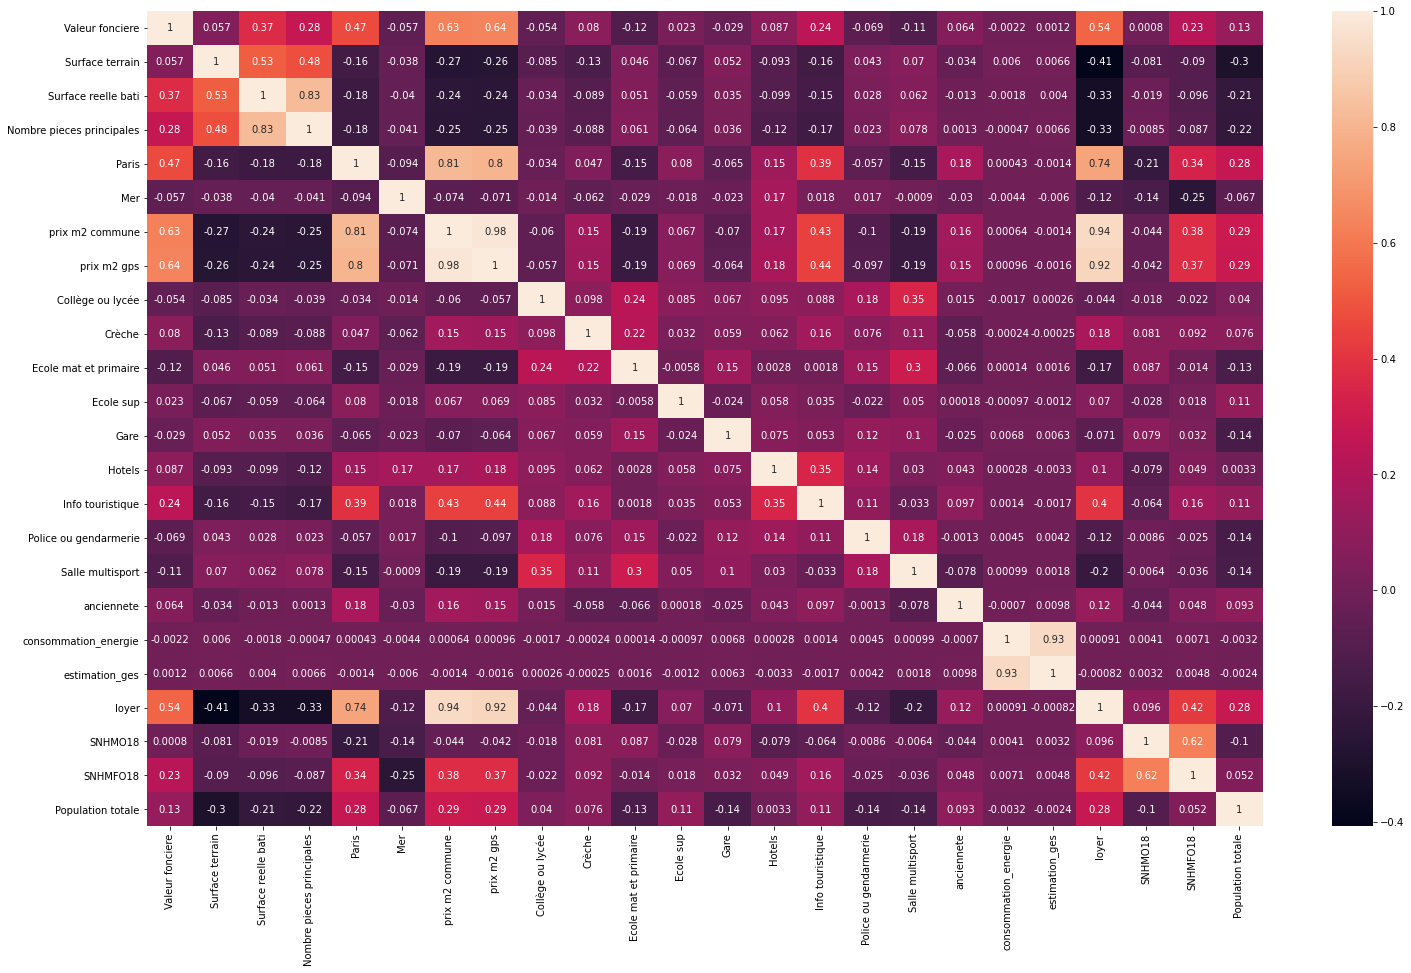

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affiche la heatmap avec les valeurs
plt.figure(figsize=(25, 15))
matrice_correlation = df.corr()
sns.heatmap(matrice_correlation, annot = True);

In [23]:
df.to_csv('databases/DVF_final_2020.csv')

## Algos de régression

On applique une régression sur l'ensemble de la base puis on réalise 3 modèles complémentaires en séparant les modèles ainsi : 
- Appartements Province
- Appartements Paris
- Maisons Province

In [24]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [25]:
df['Type local'] = df.apply(lambda x: 1 if x['Type local'] == "Maison" else 0, axis = 1)
df.head()

,Valeur fonciere,Surface terrain,Surface reelle bati,Type local,Nombre pieces principales,Paris,Mer,prix m2 commune,prix m2 gps,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Gare,Hotels,Info touristique,Police ou gendarmerie,Salle multisport,anciennete,consommation_energie,estimation_ges,loyer,SNHMO18,SNHMFO18,Population totale
32083,91000.0,444.0,78.0,1,4.0,0,0,1187.500000,1083.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,361.64,20.86,5.976415,10.984865,9.693811,623.0
32085,78000.0,0.0,40.0,0,2.0,0,0,1314.285714,1526.315789,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,239.27,11.74,10.333854,10.984865,9.693811,12768.0
32087,52000.0,0.0,45.0,0,2.0,0,0,1502.551020,1609.195402,2.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,1.0,74.0,140.00,32.00,10.246045,10.984865,9.693811,63124.0
32089,67500.0,0.0,30.0,0,2.0,0,0,1502.551020,1745.333333,2.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,81.0,0.00,0.00,10.246045,10.984865,9.693811,63124.0
32090,112000.0,505.0,84.0,1,4.0,0,0,1877.976190,1755.201300,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,3.0,43.0,287.44,15.54,8.893778,10.984865,9.693811,4760.0


In [26]:
target = df['Valeur fonciere']
print(target.median())

182200.0


In [27]:
# Test 1 : Appartements hors Paris
df_1 = df[(df['Type local'] == 0) & (df['Paris'] == 0)]
target_1 = df_1['Valeur fonciere']
df_1 = df_1.drop(columns = {'Valeur fonciere'})
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, target_1, test_size = 0.2, random_state = 1234)

# Test 2 : Appartements Paris
df_2 = df[(df['Type local'] == 0) & (df['Paris'] == 1)]
target_2 = df_2['Valeur fonciere']
df_2 = df_2.drop(columns = {'Valeur fonciere'})
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, target_2, test_size = 0.2, random_state = 1234)

# Test 3 : Maisons hors Paris
df_3 = df[(df['Type local'] == 1) & (df['Paris'] == 0)]
target_3 = df_3['Valeur fonciere']
df_3 = df_3.drop(columns = {'Valeur fonciere'})
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_3, target_3, test_size = 0.2, random_state = 1234)

In [28]:
# Affichage des prix moyens des biens
print(target_1.median())
print(target_2.median())
print(target_3.median())

155000.0
465000.0
206000.0


In [29]:
"""# Alternative : on prend les valeurs de Juin 2021 comme Test et les autres comme Train

df_train = df[df['anciennete_vente'] >= 1]
df_test = df[df['anciennete_vente'] == 0]

X_train = df_train.drop(columns = {'Valeur fonciere'})
y_train = df_train['Valeur fonciere']
X_test = df_test.drop(columns = {'Valeur fonciere'})
y_test = df_test['Valeur fonciere']"""

"# Alternative : on prend les valeurs de Juin 2021 comme Test et les autres comme Train\n\ndf_train = df[df['anciennete_vente'] >= 1]\ndf_test = df[df['anciennete_vente'] == 0]\n\nX_train = df_train.drop(columns = {'Valeur fonciere'})\ny_train = df_train['Valeur fonciere']\nX_test = df_test.drop(columns = {'Valeur fonciere'})\ny_test = df_test['Valeur fonciere']"

In [30]:
df = df.drop(columns = {'Valeur fonciere'})
df.shape

(218753, 24)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 1234)

## Modèle global (tous biens confondus)

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
# Fonction d'entraînement de modèle Random Forest

def random_forest_model(X_train, X_test, y_train, y_test):
    print('X_train.shape: ', X_train.shape)
    print('X_test.shape: ', X_test.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    regr = RandomForestRegressor(n_estimators = 50, max_depth = 500, min_samples_leaf = 5, random_state = 123)
    regr.fit(X_train, y_train)
    
    y_pred_train = regr.predict(X_train) 
    y_pred_test = regr.predict(X_test)
    
    score_train = regr.score(X_train, y_train)
    score_test = regr.score(X_test, y_test)
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_test = mean_squared_error(y_pred_test, y_test, squared=False)
    mae_train = mean_absolute_error(y_pred_train, y_train)
    mae_test = mean_absolute_error(y_pred_test, y_test)
    
    results = {'score_train': score_train, 'score_test': score_test,
              'rmse_train': rmse_train, 'rmse_test': rmse_test,
              'mae_train': mae_train, 'mae_test': mae_test}

    print("score train:", score_train)
    print("score test:", score_test)

    print("rmse train : ", rmse_train)
    print('rmse test :', rmse_test)

    print("mae train : ", mae_train)
    print('mae test :', mae_test)
    
    return regr, results

In [34]:
column_list = df.columns.values

In [35]:
# Fonction de réduction de dimension de type lasso

from sklearn.linear_model import Lasso

def reduc_dim_lasso(X_train, X_test, y_train, y_test):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_r = Lasso(alpha = 1)
    lasso_r.fit(X_train, y_train)

    sel = SelectFromModel(estimator = lasso_r, threshold = 1e-10)
    sel.fit(X_train, y_train)

    mask = sel.get_support()
    plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
    plt.xlabel('Axe des features');
    plt.show();

    # Afficher un graphique représentant la valeur estimée du coefficient pour chaque variable de data
    plt.figure(figsize = (20, 10))

    lasso_coef = lasso_r.coef_ 
    plt.bar(range(len(df.columns)), lasso_coef) 
    plt.xticks(range(len(df.columns)), column_list, rotation=70);

X_train.shape:  (175002, 24)
X_test.shape:  (43751, 24)
y_train.shape:  (175002,)
y_test.shape:  (43751,)
score train: 0.9527652172415142
score test: 0.9010055768616086
rmse train :  41090.14180040685
rmse test : 58964.197191202016
mae train :  23559.782727325677
mae test : 35120.875581336855


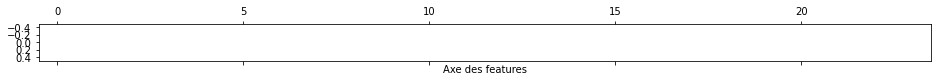

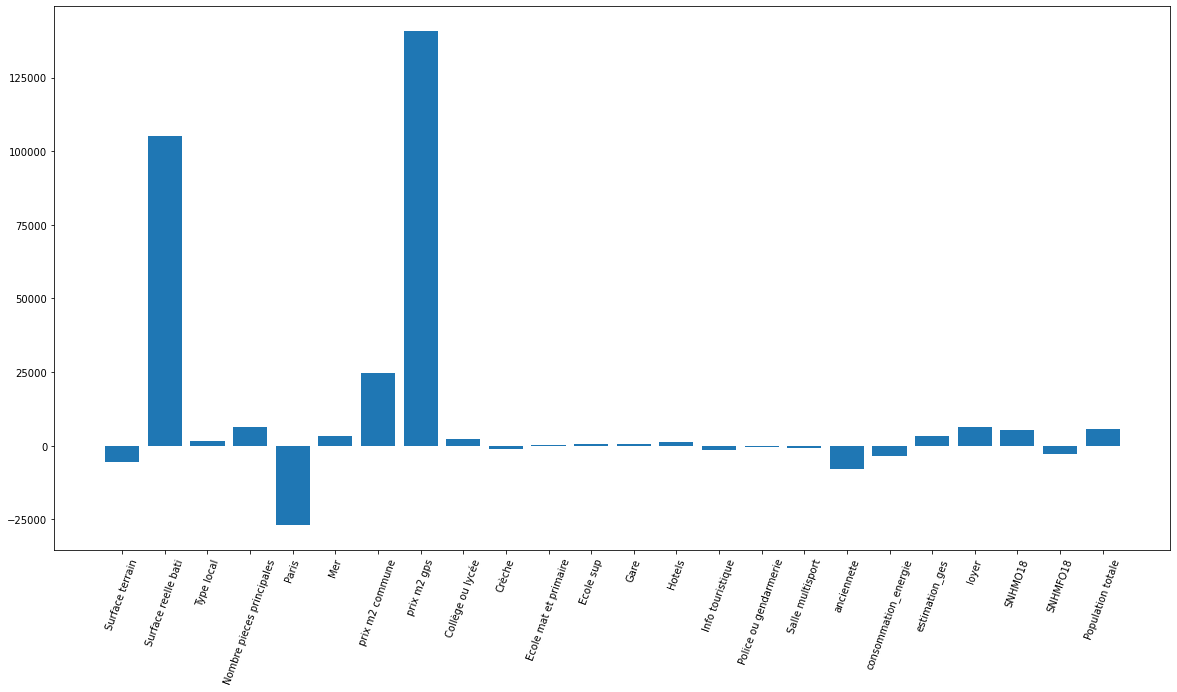

In [36]:
# Modèle global
rf_all, results_all = random_forest_model(X_train, X_test, y_train, y_test)
reduc_dim_lasso(X_train, X_test, y_train, y_test)

X_train.shape:  (92628, 24)
X_test.shape:  (23158, 24)
y_train.shape:  (92628,)
y_test.shape:  (23158,)
score train: 0.932963098546508
score test: 0.8583082512572262
rmse train :  34829.466951641014
rmse test : 50200.96987785019
mae train :  19881.09645894746
mae test : 29668.829839523525


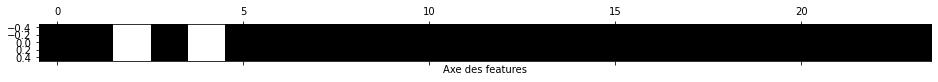

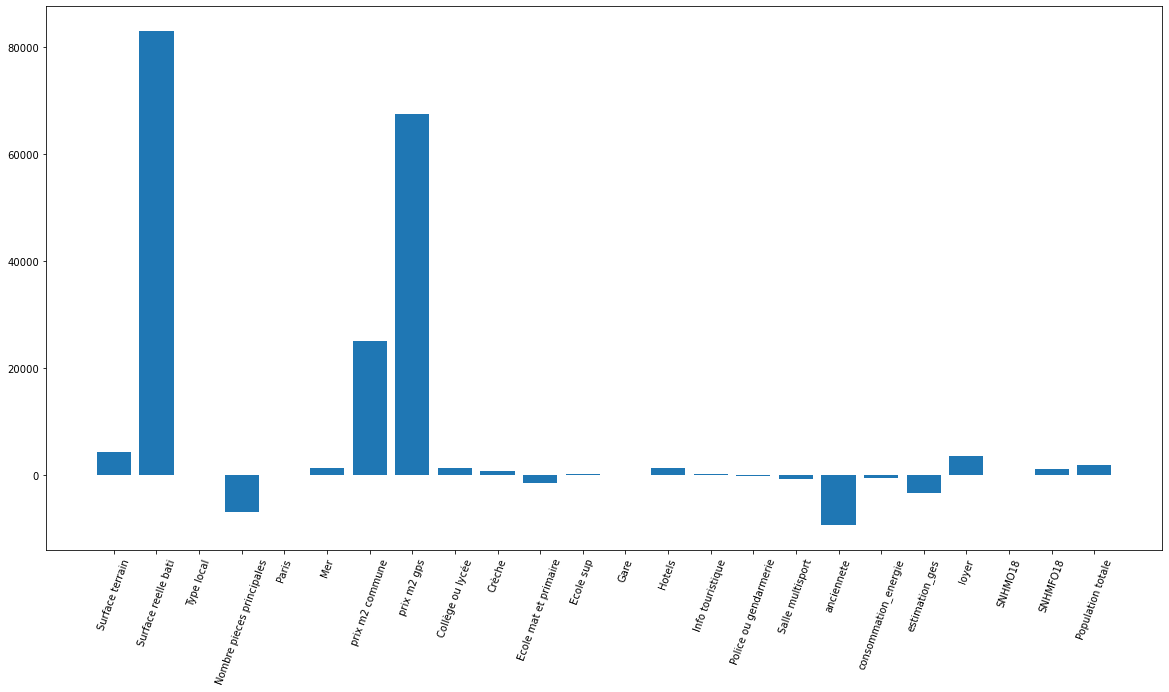

In [37]:
# Modèle 1 - Appartements hors Paris
rf_1, results_1 = random_forest_model(X_train_1, X_test_1, y_train_1, y_test_1)
reduc_dim_lasso(X_train_1, X_test_1, y_train_1, y_test_1)

X_train.shape:  (11512, 24)
X_test.shape:  (2878, 24)
y_train.shape:  (11512,)
y_test.shape:  (2878,)
score train: 0.9575542235638427
score test: 0.9095959063809431
rmse train :  74602.10102221392
rmse test : 111540.53739876807
mae train :  49703.04994044933
mae test : 73900.44621319875


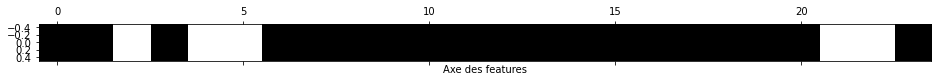

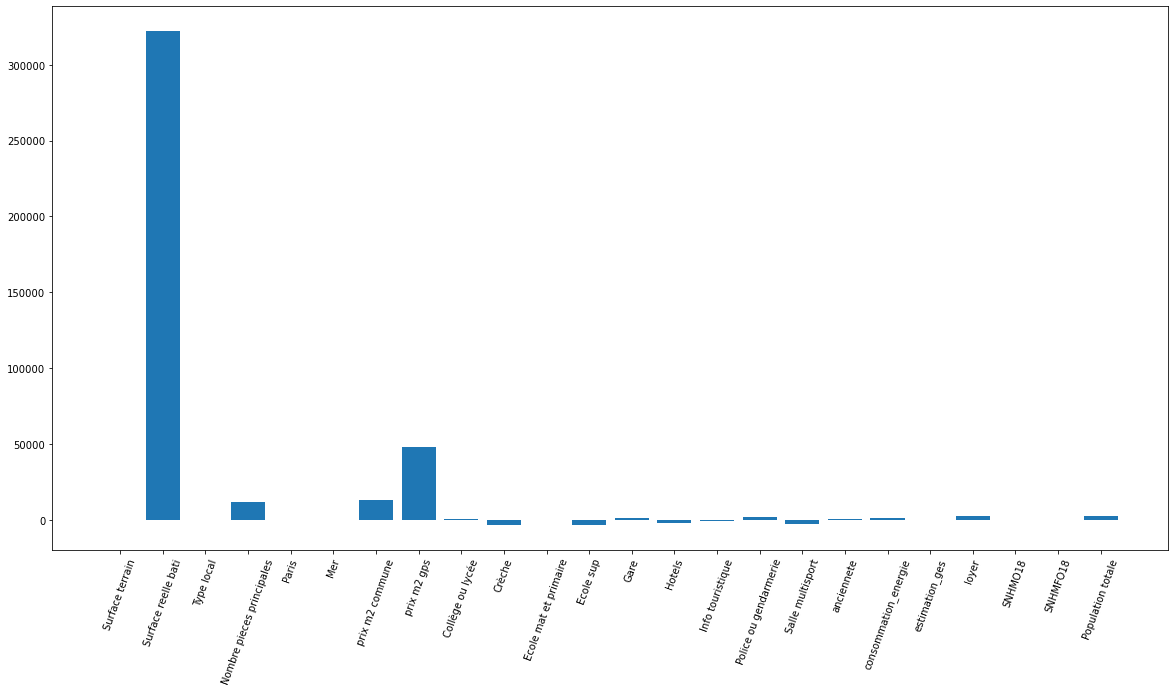

In [38]:
# Modèle 2 - Appartements Paris
rf_2, results_2 = random_forest_model(X_train_2, X_test_2, y_train_2, y_test_2)
reduc_dim_lasso(X_train_2, X_test_2, y_train_2, y_test_2)

X_train.shape:  (70854, 24)
X_test.shape:  (17714, 24)
y_train.shape:  (70854,)
y_test.shape:  (17714,)
score train: 0.9268958506996403
score test: 0.8328013025025723
rmse train :  40041.385343750415
rmse test : 60109.24337957569
mae train :  23763.21818610206
mae test : 37503.802655608895


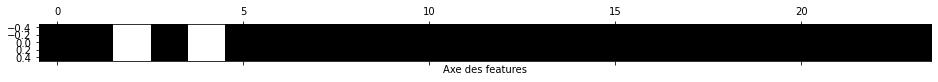

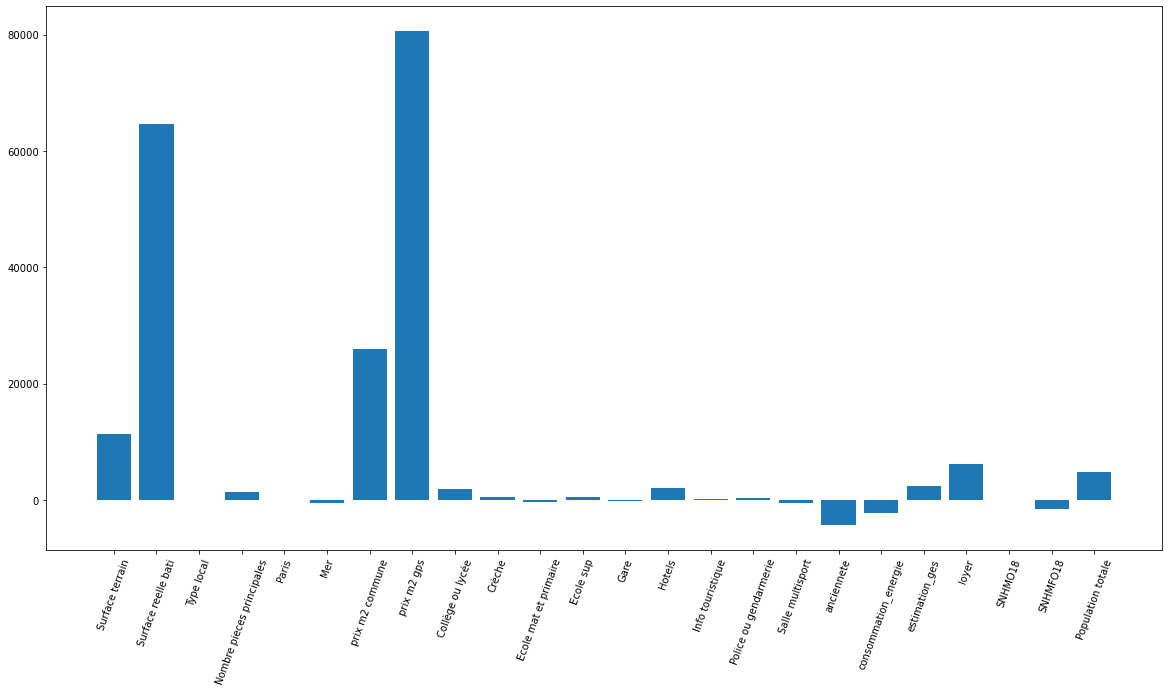

In [39]:
# Modèle 3 - Maisons Province
rf_3, results_3 = random_forest_model(X_train_3, X_test_3, y_train_3, y_test_3)
reduc_dim_lasso(X_train_3, X_test_3, y_train_3, y_test_3)

In [40]:
def print_results(model_name, results):
    print(model_name + " : ")
    print("Score Test: " + str(round(results['score_test'], 4)))
    print("MAE Test: " + str(round(results['mae_test'], 0)))
    print('\n')

print_results("Modèle global", results_all)
print_results("Modèle 1 - Appartements Province", results_1)
print_results("Modèle 2 - Appartements Paris", results_2)
print_results("Modèle 3 - Maisons Province", results_3)

Modèle global : 
Score Test: 0.901
MAE Test: 35121.0


Modèle 1 - Appartements Province : 
Score Test: 0.8583
MAE Test: 29669.0


Modèle 2 - Appartements Paris : 
Score Test: 0.9096
MAE Test: 73900.0


Modèle 3 - Maisons Province : 
Score Test: 0.8328
MAE Test: 37504.0




In [41]:
# Sauvegarde des modèles
joblib.dump(rf_all, 'models/model_rf_all.pkl', compress = 3)
joblib.dump(rf_1, 'models/model_rf_1_appart_province.pkl', compress = 3)
joblib.dump(rf_2, 'models/model_rf_2_appart_paris.pkl', compress = 3)
joblib.dump(rf_3, 'models/model_rf_3_maison_province.pkl', compress = 3)

['models/model_rf_3_maison_province.pkl']

In [42]:
# Export de la liste des colonnes de X_train
feature_list = list(X_train.columns)

df_feat = pd.DataFrame({'feature_name': feature_list})
#df_feat = pd.DataFrame({'feature_name': feature_list}, index = [i for i in range (0, len(feature_list))])
df_feat.to_csv('models/features_list_for_model_A.csv')

In [43]:
### Archive Recherche Meilleurs Hyperparamètres

"""
{'max_depth': 500, 'min_samples_leaf': 5, 'n_estimators': 50}



rf = RandomForestRegressor(max_features='sqrt')  

param_grid = {  
           "n_estimators" : [20, 50, 100],  
           "max_depth" : [250, 500, 1000],  
           "min_samples_leaf" : [5, 15, 25]}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  
CV_rf.fit(X_train, y_train)  
print(CV_rf.best_params_)"""

'\n{\'max_depth\': 500, \'min_samples_leaf\': 5, \'n_estimators\': 50}\n\n\n\nrf = RandomForestRegressor(max_features=\'sqrt\')  \n\nparam_grid = {  \n           "n_estimators" : [20, 50, 100],  \n           "max_depth" : [250, 500, 1000],  \n           "min_samples_leaf" : [5, 15, 25]}\n\nCV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  \nCV_rf.fit(X_train, y_train)  \nprint(CV_rf.best_params_)'

## Interprétabilité du modèle

In [44]:
import shap
shap.initjs()

explainerModel = shap.TreeExplainer(rf_2)
shap_values = explainerModel.shap_values(X_test_2)

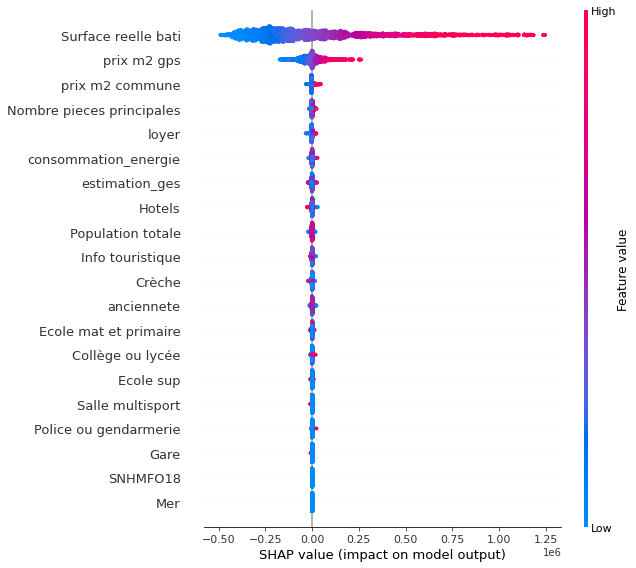

In [45]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_test_2)


In [46]:
shap.force_plot(explainerModel.expected_value, shap_values[1], feature_list)

### Export des autres modèles pour comparaison

In [47]:
# Test XG Boost peu concluant pour l'instant

import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.1, learning_rate = 0.2,
                max_depth = 20, alpha = 10, n_estimators = 50)

xg_reg.fit(X_train,y_train)

xg_pred_train = xg_reg.predict(X_train) 
xg_pred_test = xg_reg.predict(X_test) 

print("score train:", xg_reg.score(X_train, y_train))
print("score test:", xg_reg.score(X_test, y_test))

print("rmse train : ", mean_squared_error(xg_pred_train, y_train, squared=False))
print('rmse test :', mean_squared_error(xg_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(xg_pred_train, y_train))
print('mae test :', mean_absolute_error(xg_pred_test, y_test))

score train: 0.8980968861486818
score test: 0.8213216327893484
rmse train :  60353.21451556953
rmse test : 79217.11336552218
mae train :  35361.73235843428
mae test : 47417.45272944449


In [59]:
# Sauvegarde du modèle XG Boost
joblib.dump(xg_reg, 'models/model_xgb_all.pkl', compress = 3)

['models/model_xgb_all.pkl']

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', lr.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', lr.score(X_test, y_test))

lr_pred_train = lr.predict(X_train) 
lr_pred_test = lr.predict(X_test) 
print('rmse train :', mean_squared_error(lr_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(lr_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(lr_pred_train, y_train))
print('mae test :', mean_absolute_error(lr_pred_test, y_test))

Coefficient de détermination du modèle : 0.71948732942101
Score sur le jeu de test : 0.7151545343784449
rmse train : 100134.31247079669
rmse test : 100020.19121918554
mae train :  61050.12273364997
mae test : 60403.147214849094


In [50]:
# Sauvegarde du modèle Linear Regression
joblib.dump(lr, 'models/model_lr_all.pkl', compress = 3)

['models/model_lr_all.pkl']

In [51]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', svr.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', svr.score(X_test, y_test))

svr_pred_train = svr.predict(X_train) 
svr_pred_test = svr.predict(X_test) 
print('rmse train :', mean_squared_error(svr_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(svr_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(svr_pred_train, y_train))
print('mae test :', mean_absolute_error(svr_pred_test, y_test))

Coefficient de détermination du modèle : -0.08033721490752366
Score sur le jeu de test : -0.0787278185952287
rmse train : 196510.76539649875
rmse test : 194643.07838968784
mae train :  115834.52316906022
mae test : 114619.85397466953


In [52]:
# Sauvegarde du modèle Support Vector Regression
joblib.dump(svr, 'models/model_svr_all.pkl', compress = 3)

['models/model_svr_all.pkl']

In [64]:
from sklearn import neighbors
knn5 = neighbors.KNeighborsRegressor(n_neighbors = 5)
knn5.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', knn5.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', knn5.score(X_test, y_test))

knn5_pred_train = knn5.predict(X_train) 
knn5_pred_test = knn5.predict(X_test) 
print('rmse train :', mean_squared_error(knn5_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(knn5_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(knn5_pred_train, y_train))
print('mae test :', mean_absolute_error(knn5_pred_test, y_test))

Coefficient de détermination du modèle : 0.8426092367981967
Score sur le jeu de test : 0.7564794404984508
rmse train : 75006.05076654875
rmse test : 92480.64323099659
mae train :  45988.65135377881
mae test : 56874.97566044205


In [65]:
# Sauvegarde du modèle KNN-5
joblib.dump(knn5, 'models/model_knn5_all.pkl', compress = 3)

['models/model_knn5_all.pkl']

In [62]:
from sklearn import neighbors
knn2 = neighbors.KNeighborsRegressor(n_neighbors = 2)
knn2.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', knn2.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', knn2.score(X_test, y_test))

knn2_pred_train = knn2.predict(X_train) 
knn2_pred_test = knn2.predict(X_test) 
print('rmse train :', mean_squared_error(knn2_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(knn2_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(knn2_pred_train, y_train))
print('mae test :', mean_absolute_error(knn2_pred_test, y_test))

Coefficient de détermination du modèle : 0.9231547471362856
Score sur le jeu de test : 0.7463703771269898
rmse train : 52410.12564444125
rmse test : 94380.66070271445
mae train :  31849.49900421137
mae test : 57884.38714235103


In [66]:
# Sauvegarde du modèle KNN-2
joblib.dump(knn2, 'models/model_knn2_all.pkl', compress = 3)

['models/model_knn2_all.pkl']

In [55]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=0)
dtree.fit(X_train, y_train)

# Score R2 du modèle d'apprentissage
print('Coefficient de détermination du modèle :', dtree.score(X_train, y_train))

# Score R2 sur le jeu de test
print('Score sur le jeu de test :', dtree.score(X_test, y_test))

dtree_pred_train = dtree.predict(X_train) 
dtree_pred_test = dtree.predict(X_test) 
print('rmse train :', mean_squared_error(dtree_pred_train, y_train, squared=False)) 
print('rmse test :', mean_squared_error(dtree_pred_test, y_test, squared=False))

print("mae train : ", mean_absolute_error(dtree_pred_train, y_train))
print('mae test :', mean_absolute_error(dtree_pred_test, y_test))

Coefficient de détermination du modèle : 0.9986506573863867
Score sur le jeu de test : 0.802292890383005
rmse train : 6944.928787145339
rmse test : 83328.61601105168
mae train :  1171.892106855304
mae test : 50207.53271185323


In [61]:
# Sauvegarde du modèle Decision Tree
joblib.dump(dtree, 'models/model_dtree_all.pkl', compress = 3)

['models/model_dtree_all.pkl']